## Automated Evaluation for KWS Under Different Noise Scenarios


Using this notebook, you can test previously trained KWS models under various noise types at desired SNR levels. You'll need:
- the trained model's checkpoint file
- a list specifying the types of noise
- a list specifying the SNR levels.

This notebook uses the signalmixer data loader to mix the KWS and specified noise data, and creates a mixed dataset using the specified SNR level. The notebook performs the evaluation on these mixed datasets and creates comparison plots for different types of models.

In [1]:
###################################################################################################
#
# Copyright (C) 2023-2024 Analog Devices, Inc. All Rights Reserved.
#
# Analog Devices, Inc. Default Copyright Notice:
# https://www.analog.com/en/about-adi/legal-and-risk-oversight/intellectual-property/copyright-notice.html
#
###################################################################################################
#
# Copyright (C) 2022-2023 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

import os
import sys

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

import torchnet.meter as tnt
from collections import OrderedDict
import importlib
from torchvision import transforms

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', 'models'))
sys.path.append(os.path.join(os.getcwd(), '..', 'datasets'))

from types import SimpleNamespace

import ai8x

import msnoise
import signalmixer

### Step 1: Initialize and load the model

First, set the checkpoint path and the corresponding model name. 

In [2]:
trained_checkpoint_path = os.path.join('..', '..', 'ai8x-synthesis', 'trained', 'ai85-kws20_nas-qat8.pth.tar')
mod = importlib.import_module("ai85net-kws20-nas")
model_file = "ai85net-kws20-nas"

In [3]:
dataset = importlib.import_module("kws20")

classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [4]:
model = mod.AI85KWS20NetNAS(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)

In [5]:
checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

### Step 2: Set up the test set and evaluation parameters

Then, load the KWS test set, specify the noise list and the SNR level list. 

Note: Noise types should be picked from the available classes within the MSnoise dataset (`datasets/msnoise.py`).

In [6]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

data_path = '/data_ssd'

_, test_dataset = dataset.KWS_20_get_datasets( (data_path, sn), load_train=False, load_test=True)


Processing test...
test set: 11005 elements
Class up (# 31): 425 elements
Class down (# 5): 406 elements
Class left (# 15): 412 elements
Class right (# 23): 396 elements
Class stop (# 27): 411 elements
Class go (# 11): 402 elements
Class yes (# 34): 419 elements
Class no (# 19): 405 elements
Class on (# 21): 396 elements
Class off (# 20): 402 elements
Class one (# 22): 399 elements
Class two (# 30): 424 elements
Class three (# 28): 405 elements
Class four (# 10): 400 elements
Class five (# 7): 445 elements
Class six (# 26): 394 elements
Class seven (# 24): 406 elements
Class eight (# 6): 408 elements
Class nine (# 18): 408 elements
Class zero (# 35): 418 elements
Class UNKNOWN: 2824 elements


In [7]:
noise_list = ['AirConditioner',
            'AirportAnnouncements',
            'Babble',
            'CopyMachine',
            'Munching',
            'NeighborSpeaking',
            'ShuttingDoor',
            'Typing',
            'VacuumCleaner',
            'TradeShow',
            'WhiteNoise']

In [8]:
snr_list = [-5, 0, 5, 10, 15, 20, 25, 30]

### Step 3: Define functions to evaluate the model under different SNR levels

Using the `evaluate`, `snr_testing` and `benchmark` functions, you can evaluate the trained model under different SNR levels.

- The `evaluate` function evaluates the model under the specified SNR level and noise type.
- The `snr_testing` function executes a loop over the SNR list. It calls the `evaluate` function for each SNR level, for the specified noise type.
- The `benchmark` function executes a loop over the list of noise types. It calls the `snr_testing` function for each type of noise.

In [9]:
def evaluate(db = None, noise = False, noise_kind = None):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device) 
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))

    transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
    if noise:
        if (noise_kind == 'WhiteNoise'):

            mixed_signals = signalmixer.signalmixer(test_dataset, snr_range = [db], noise_type = noise_kind, noise_dataset = None)
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)

        else:
            noise_dataset = msnoise.MSnoise(root = data_path, classes = [noise_kind], d_type = 'test', dataset_len = 11005,
                                            desired_probs = None,
                                            transform=None, quantize=False, download=False)
            mixed_signals = signalmixer.signalmixer(signal_dataset=test_dataset, snr_range=[db],
                                    noise_type=noise_kind,
                                    noise_dataset=noise_dataset)
            
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)
    else:
        mixed_signals_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256)
        
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(mixed_signals_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(test_dataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            
    print("Total Accuracy: ", acc)
    return acc

In [10]:
def snr_testing(snr_list = None, noise_type = None, noise = False):

    # raw test set evaluation
    if noise == False:
        db = None
        noise_type = None
        accuracies = np.zeros(1)
        accuracies[0] = evaluate(db, noise, noise_type)

    # noisy test set evaluation
    else:
        accuracies = np.zeros(len(snr_list))

        for idx, db in enumerate(snr_list):
            print("Evaluating SNR levels of", db)
            accuracies[idx] = evaluate(db, noise, noise_type)

    return accuracies

In [11]:
def benchmark(noise_list = None, snr_list = None):

    if noise_list == None:
        print('Noise type is not specified. Noise will not be applied.')
        noise = False
        snr_list = None
    else:
        noise = True
        if snr_list == None:
            print('Using default values for SNR levels: [-5, 20] dB.')
            snr_list = range(-5, 20)

    if noise:

        accuracies = np.zeros((len(noise_list) + 1, len(snr_list)))

        for idx, n in enumerate(noise_list):
            print(f'{n} Noise Evaluation')
            accuracies[idx] = snr_testing(snr_list, noise_type = n, noise = noise)

    accuracies[-1] = snr_testing(noise = False)

    return accuracies  

In [ ]:
accuracies_nas = benchmark(noise_list = noise_list, snr_list = snr_list)
accuracies = [accuracies_nas]

### Optional Step: Adding different models for comparison

- v3 Model

In [ ]:
trained_checkpoint_path = os.path.join('..', '..', 'ai8x-synthesis', 'trained', 'ai85-kws20_v3-qat8.pth.tar')              
mod = importlib.import_module("ai85net-kws20-v3")
model_file = "ai85net-kws20-v3"

checkpoint = torch.load(trained_checkpoint_path)

model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

accuracies_v3 = benchmark(noise_list = noise_list, snr_list = snr_list)

- v2 Model

In [ ]:
trained_checkpoint_path = os.path.join('..', '..', 'ai8x-synthesis', 'trained', 'ai85-kws20_v2-qat8.pth.tar')
mod = importlib.import_module("ai85net-kws20-v2")
model_file = "ai85net-kws20-v2"

checkpoint = torch.load(trained_checkpoint_path)

model = mod.AI85KWS20Netv2(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

accuracies_v2 = benchmark(noise_list = noise_list, snr_list = snr_list)

In [ ]:
accuracies = [accuracies_nas, accuracies_v2, accuracies_v3]
model_files = ["ai85net-kws20-nas", "ai85net-kws20-v2", "ai85net-kws20-v3"]

### Step 4: Comparing noise types (for specified models)

You can create data frames to examine the results of evaluation. Using the data frame, you can create plots to compare noise types for each model.

In [ ]:
accs = []
for model_name, model_acc in enumerate(accuracies):
    csv = {}

    for idx, i in enumerate(noise_list):
        csv[i] = model_acc[idx]
            
        csv_list = []
        csv_list.append(['raw', 'None', model_acc[-1][0]])

        for i in csv.keys():
            for idx, j in enumerate(csv[i]):
                csv_list.append([i, snr_list[idx], j])

        df = pd.DataFrame(csv_list, columns = ['Type', 'SNR (dB)', f'{model_files[model_name]}'])
        
    accs.append(df)

for i in accs:
    df[i.columns[-1]] = i[i.columns[-1]]

In [19]:
df

,Type,SNR (dB),ai85net-kws20-v3,ai85net-kws20-nas,ai85net-kws20-v2
0,raw,None,90.867787,93.757383,91.958201
1,AirConditioner,-5,35.483871,46.742390,39.563835
2,AirConditioner,0,58.037256,70.713312,65.588369
3,AirConditioner,5,75.611086,83.371195,81.426624
4,AirConditioner,10,84.225352,88.832349,87.796456
...,...,...,...,...,...
84,WhiteNoise,10,88.132667,91.731031,90.131758
85,WhiteNoise,15,89.613812,92.839618,91.231259
86,WhiteNoise,20,90.240800,93.275784,91.649250
87,WhiteNoise,25,90.831440,93.584734,91.967288


In [20]:
def plot_values(model_num):

    accuracies_values = {}

    for noise in noise_list:
        acc_list = []
        for idx, i in enumerate(df['Type'].values[1:]): 
            if i == noise:
                acc_list.append(df[model_num][1:][idx+1])
        accuracies_values[noise] = acc_list

    return accuracies_values

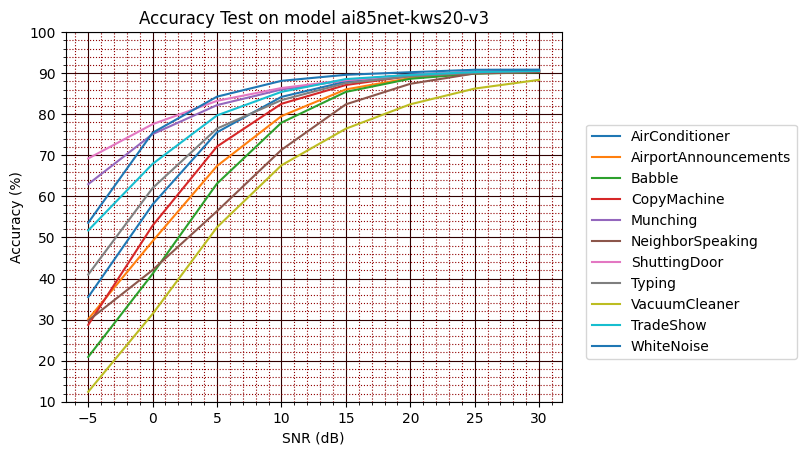

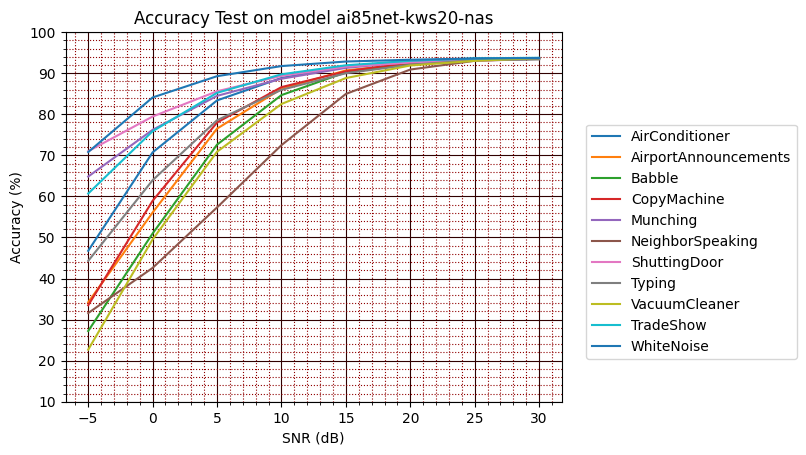

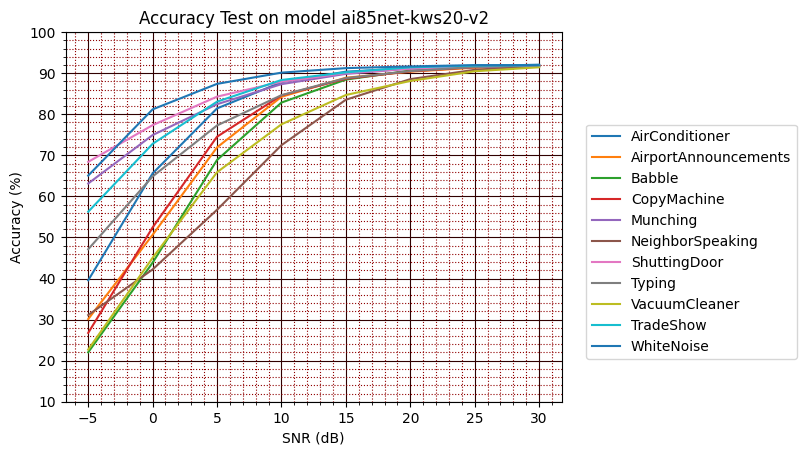

In [24]:
for model_num in df.columns[2:]:
    accuracies_values = plot_values(model_num)
    plt.figure()
    plt.grid(visible=True, which='major', color='#300000', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#900000', linestyle=':')
    for noise in noise_list:
        plt.title(f'Accuracy Test on model {model_num}')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr_list, accuracies_values[noise])
    
    plt.ylim(10, 100)

    plt.legend(noise_list, bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)

### Step 5: Comparing different models (for specified noise types)

You can also see the comparison between each model for each noise type separately.

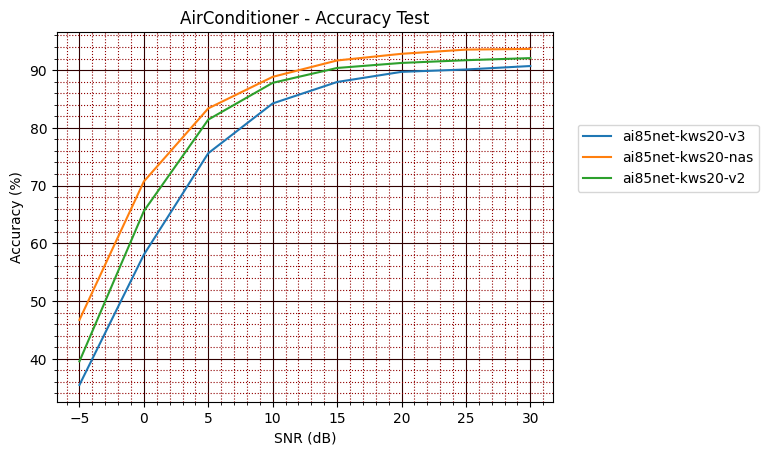

In [25]:
acc_list = []
for model_num in df.columns[2:]:
    acc_list.append(plot_values(model_num))
    
for noise in noise_list:
    plt.figure()
    plt.grid(visible=True, which='major', color='#300000', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#900000', linestyle=':')
    plt.title(f'{noise} - Accuracy Test')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    for model in acc_list:
        plt.plot(snr_list , model[noise])
    plt.legend(df.columns[2:], bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
    
    # you can remove the break to see all noise type comparisons
    break

### Optional Step: Export to CSV

You may also export the evaluation data to CSV files using the data frames calculated above. If the current model file is already in the CSV file, accuracies will not be added to the CSV file. Otherwise, the current accuracy results will be added to the CSV file as a new column.

Note: Please make sure that you test the same noise types for the same SNR levels for all of the models.

In [23]:
if os.path.exists('KWS_snr_test.csv'):
    current = pd.read_csv('KWS_snr_test.csv', decimal=',', sep=';')
    if model_file in current.columns:
        print(f'This model file ({model_file}) already exists!')
    else:
        current[model_file] = list(df[model_file].values)
        current.to_csv('KWS_snr_test.csv', sep=';', decimal=',', index=False)

else:
    df.to_csv('KWS_snr_test.csv', sep=';', decimal=',', index=False)

### Training Updates

We proposed a new training scenario using the signalmixer data loader. 

- The `apply_prob` parameter shows the amount of data that additional noise will be applied and it is set to 0.8 (%80).
- The `snr_range` parameter shows the range that is going to applied and it is set to the range [-5, 10] dB for all additional noise types.
- The `noise_type` parameter shows the noise types that will be applied and it is set to include all noise types.

The KWS data loader is updated with a new White Noise application. The SNR range selected for White Noise is [-5, 20] dB.

In [ ]:
trained_checkpoint_path = os.path.join('..', '..', 'ai8x-synthesis', 'trained', 'ai85-kws20_v3-qat8.pth.tar')              
mod = importlib.import_module("ai85net-kws20-v3")
model_file = "ai85net-kws20-v3"

checkpoint = torch.load(trained_checkpoint_path)

model = mod.AI85KWS20NetNAS(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

accuracies_updated = benchmark(noise_list = noise_list, snr_list = snr_list)